In [ ]:
!pip install nb-black

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import sys

sys.path.insert(0, "../")

## Dataset

In [3]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [5]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    ToNumpy(),
    BandPass(
        attenuation=attenuation,
        lowcut=lowcut,
        highcut=highcut,
        fs=fs,
        interval=interval,
    ),
    ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    # ExpandDim(dim=2),
    # ExpandDim(dim=2),
    Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    in_mem=True,
)

In [6]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-8.1779, dtype=torch.float64) tensor(8.1676, dtype=torch.float64)
torch.Size([1, 22, 1, 9, 1001])


In [7]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [15]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Model

In [16]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

In [17]:
import torch.optim as optim

In [18]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [24]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        self.fc1 = nn.Linear(
            self.num_bands * self.num_windows * self.num_labels * self.num_features, 500
        )
        self.fc = nn.Linear(500, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        x = torch.tanh(self.fc1(features))
        x = F.dropout(x, 0.5)

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22,
    num_features=22,
    num_bands=9,
    num_windows=1,
    num_labels=4,
    mode="csp",
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# net = net.to("cuda")
optimizer = optim.SGD(
    net.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0
)

# optimizer = optim.SGD(
#     [
#         {"params": net.conv1.parameters()},
#         {"params": net.fc1.parameters(), "weight_decay": 5e-3},
#         {"params": net.fc.parameters()},
#     ],
#     lr=0.001,
#     momentum=0.9,
#     nesterov=True,
#     weight_decay=0,
# )

# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [25]:
signals = torch.empty((10, 22, 1, 9, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 36, 22]))

## Train Loop

In [28]:
net = net.cuda()
# net = net.to("cuda")
net

CSPNNCls(
  (conv1): CSPNN(
    (cspw): ModuleDict(
      (label-1_band-0_window-0): CSP()
      (label-1_band-1_window-0): CSP()
      (label-1_band-2_window-0): CSP()
      (label-1_band-3_window-0): CSP()
      (label-1_band-4_window-0): CSP()
      (label-1_band-5_window-0): CSP()
      (label-1_band-6_window-0): CSP()
      (label-1_band-7_window-0): CSP()
      (label-1_band-8_window-0): CSP()
      (label-2_band-0_window-0): CSP()
      (label-2_band-1_window-0): CSP()
      (label-2_band-2_window-0): CSP()
      (label-2_band-3_window-0): CSP()
      (label-2_band-4_window-0): CSP()
      (label-2_band-5_window-0): CSP()
      (label-2_band-6_window-0): CSP()
      (label-2_band-7_window-0): CSP()
      (label-2_band-8_window-0): CSP()
      (label-3_band-0_window-0): CSP()
      (label-3_band-1_window-0): CSP()
      (label-3_band-2_window-0): CSP()
      (label-3_band-3_window-0): CSP()
      (label-3_band-4_window-0): CSP()
      (label-3_band-5_window-0): CSP()
      (label

In [30]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "train_kappa": [],
    "test_kappa": [],
    "train_fmeasure": [],
    "test_fmeasure": [],
    "lr": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    # params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    params = ["acc", "kappa", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])
    history["train_fmeasure"].append(tr[2])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])
    history["test_fmeasure"].append(ev[2])


Epoch  0


81it [00:20,  4.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.389783928423752


Train -  [0.24614197530864199, -0.005144032921810648, 0.24614197530864199, tensor(1.3947)]
Validation -  [0.24382716049382716, -0.008230452674897082, 0.24382716049382716, tensor(1.3953)]

Epoch  1


81it [00:19,  4.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.390253471739498


Train -  [0.2550154320987654, 0.006687242798353865, 0.2550154320987654, tensor(1.3893)]
Validation -  [0.24691358024691357, -0.004115226337448652, 0.24691358024691357, tensor(1.3943)]

Epoch  2


81it [00:19,  4.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3887624593428622


Train -  [0.25462962962962965, 0.006172839506172867, 0.25462962962962965, tensor(1.3932)]
Validation -  [0.2515432098765432, 0.002057613168724326, 0.2515432098765432, tensor(1.3884)]

Epoch  3


81it [00:19,  4.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3931716548071966


Train -  [0.2611882716049383, 0.014917695473251058, 0.2611882716049383, tensor(1.3910)]
Validation -  [0.24807098765432098, -0.002572016460905324, 0.24807098765432098, tensor(1.3946)]

Epoch  4


81it [00:20,  3.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3939616076740218


Train -  [0.27353395061728397, 0.03137860082304522, 0.27353395061728397, tensor(1.3858)]
Validation -  [0.24768518518518517, -0.0030864197530864335, 0.24768518518518517, tensor(1.3912)]

Epoch  5


81it [00:19,  4.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.386555000587746


Train -  [0.2654320987654321, 0.020576131687242816, 0.2654320987654321, tensor(1.3877)]
Validation -  [0.2662037037037037, 0.021604938271604923, 0.2662037037037037, tensor(1.3874)]

Epoch  6


81it [00:19,  4.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3896874056922064


Train -  [0.25925925925925924, 0.012345679012345734, 0.25925925925925924, tensor(1.3867)]
Validation -  [0.24729938271604937, -0.0036008230452675427, 0.24729938271604937, tensor(1.3948)]

Epoch  7


81it [00:19,  4.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3903595164970115


Train -  [0.2662037037037037, 0.021604938271604923, 0.2662037037037037, tensor(1.3855)]
Validation -  [0.2527006172839506, 0.0036008230452675427, 0.2527006172839506, tensor(1.3903)]

Epoch  8


81it [00:20,  4.02it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3835473987791274


Train -  [0.25308641975308643, 0.004115226337448541, 0.25308641975308643, tensor(1.3885)]
Validation -  [0.27584876543209874, 0.034465020576131655, 0.27584876543209874, tensor(1.3847)]

Epoch  9


81it [00:19,  4.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3877666894300484


Train -  [0.2743055555555556, 0.03240740740740744, 0.2743055555555556, tensor(1.3828)]
Validation -  [0.27816358024691357, 0.03755144032921809, 0.27816358024691357, tensor(1.3882)]

Epoch  10


81it [00:20,  4.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3883356238588875


Train -  [0.2785493827160494, 0.0380658436213992, 0.2785493827160494, tensor(1.3845)]
Validation -  [0.26003086419753085, 0.013374485596707841, 0.26003086419753085, tensor(1.3886)]

Epoch  11


81it [00:20,  3.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3885853849811318


Train -  [0.2789351851851852, 0.038580246913580196, 0.2789351851851852, tensor(1.3832)]
Validation -  [0.25540123456790126, 0.007201646090534974, 0.25540123456790126, tensor(1.3890)]

Epoch  12


81it [00:19,  4.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3862359597359175


Train -  [0.26080246913580246, 0.014403292181069949, 0.26080246913580246, tensor(1.3943)]
Validation -  [0.2689043209876543, 0.025205761316872466, 0.2689043209876543, tensor(1.3951)]

Epoch  13


81it [00:19,  4.17it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3917070965708038


Train -  [0.26350308641975306, 0.01800411522633749, 0.26350308641975306, tensor(1.3861)]
Validation -  [0.25848765432098764, 0.011316872427983515, 0.25848765432098764, tensor(1.3887)]

Epoch  14


81it [00:20,  3.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3861861685175954


Train -  [0.2785493827160494, 0.0380658436213992, 0.2785493827160494, tensor(1.3858)]
Validation -  [0.26851851851851855, 0.024691358024691357, 0.26851851851851855, tensor(1.3862)]

Epoch  15


81it [00:19,  4.24it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3872401155071494


Train -  [0.2716049382716049, 0.028806584362139898, 0.2716049382716049, tensor(1.3844)]
Validation -  [0.2527006172839506, 0.0036008230452675427, 0.2527006172839506, tensor(1.3912)]

Epoch  16


81it [00:19,  4.19it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.388127668404285


Train -  [0.2789351851851852, 0.038580246913580196, 0.2789351851851852, tensor(1.3824)]
Validation -  [0.2681327160493827, 0.024176954732510247, 0.2681327160493827, tensor(1.3868)]

Epoch  17


81it [00:19,  4.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3856898251874947


Train -  [0.27276234567901236, 0.030349794238683114, 0.27276234567901236, tensor(1.3863)]
Validation -  [0.2665895061728395, 0.022119341563786032, 0.2665895061728395, tensor(1.3884)]

Epoch  18


81it [00:20,  3.99it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3807198221300856


Train -  [0.27314814814814814, 0.030864197530864224, 0.27314814814814814, tensor(1.3849)]
Validation -  [0.25887345679012347, 0.011831275720164625, 0.25887345679012347, tensor(1.3930)]

Epoch  19


81it [00:19,  4.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3861825009922923


Train -  [0.27739197530864196, 0.03652263374485598, 0.27739197530864196, tensor(1.3818)]
Validation -  [0.27314814814814814, 0.030864197530864224, 0.27314814814814814, tensor(1.3864)]

Epoch  20


81it [00:19,  4.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3822026193877797


Train -  [0.26697530864197533, 0.02263374485596703, 0.26697530864197533, tensor(1.3842)]
Validation -  [0.2646604938271605, 0.019547325102880708, 0.2646604938271605, tensor(1.3915)]

Epoch  21


81it [00:19,  4.21it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3824004302790136


Train -  [0.29128086419753085, 0.05504115226337447, 0.29128086419753085, tensor(1.3783)]
Validation -  [0.2762345679012346, 0.034979423868312765, 0.2762345679012346, tensor(1.3836)]

Epoch  22


81it [00:19,  4.21it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.376998061015282


Train -  [0.2689043209876543, 0.025205761316872466, 0.2689043209876543, tensor(1.3867)]
Validation -  [0.2654320987654321, 0.020576131687242816, 0.2654320987654321, tensor(1.3910)]

Epoch  23


81it [00:19,  4.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3806054062313504


Train -  [0.27314814814814814, 0.030864197530864224, 0.27314814814814814, tensor(1.3817)]
Validation -  [0.27739197530864196, 0.03652263374485598, 0.27739197530864196, tensor(1.3846)]

Epoch  24


81it [00:19,  4.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3789872975996982


Train -  [0.279320987654321, 0.039094650205761305, 0.279320987654321, tensor(1.3786)]
Validation -  [0.26273148148148145, 0.016975308641975273, 0.26273148148148145, tensor(1.3915)]

Epoch  25


81it [00:19,  4.06it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3754871524410484


Train -  [0.2804783950617284, 0.04063786008230452, 0.2804783950617284, tensor(1.3837)]
Validation -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3910)]

Epoch  26


81it [00:19,  4.08it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3762429496388378


Train -  [0.29282407407407407, 0.0570987654320988, 0.29282407407407407, tensor(1.3793)]
Validation -  [0.27276234567901236, 0.030349794238683114, 0.27276234567901236, tensor(1.3862)]

Epoch  27


81it [00:20,  4.03it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3797226261209559


Train -  [0.27546296296296297, 0.03395061728395066, 0.27546296296296297, tensor(1.3826)]
Validation -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3936)]

Epoch  28


81it [00:20,  4.04it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3796372325332076


Train -  [0.3121141975308642, 0.08281893004115226, 0.3121141975308642, tensor(1.3719)]
Validation -  [0.26427469135802467, 0.0190329218106996, 0.26427469135802467, tensor(1.3830)]

Epoch  29


81it [00:19,  4.16it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3755147839769906


Train -  [0.2943672839506173, 0.05915637860082301, 0.2943672839506173, tensor(1.3753)]
Validation -  [0.2770061728395062, 0.03600823045267487, 0.2770061728395062, tensor(1.3823)]

Epoch  30


81it [00:19,  4.07it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3761542005303464


Train -  [0.29398148148148145, 0.058641975308642014, 0.29398148148148145, tensor(1.3762)]
Validation -  [0.2692901234567901, 0.025720164609053464, 0.2692901234567901, tensor(1.3851)]

Epoch  31


81it [00:18,  4.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3742633572331182


Train -  [0.32060185185185186, 0.09413580246913578, 0.32060185185185186, tensor(1.3691)]
Validation -  [0.2986111111111111, 0.06481481481481477, 0.2986111111111111, tensor(1.3771)]

Epoch  32


81it [00:19,  4.21it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3741868852097312


Train -  [0.28510802469135804, 0.04681069958847739, 0.28510802469135804, tensor(1.3824)]
Validation -  [0.2862654320987654, 0.048353909465020606, 0.2862654320987654, tensor(1.3867)]

Epoch  33


81it [00:19,  4.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3757592910601768


Train -  [0.30401234567901236, 0.07201646090534974, 0.30401234567901236, tensor(1.3726)]
Validation -  [0.26967592592592593, 0.026234567901234573, 0.26967592592592593, tensor(1.3833)]

Epoch  34


81it [00:19,  4.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.373286678467268


Train -  [0.3001543209876543, 0.0668724279835391, 0.3001543209876543, tensor(1.3711)]
Validation -  [0.27584876543209874, 0.034465020576131655, 0.27584876543209874, tensor(1.3822)]

Epoch  35


81it [00:20,  3.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3757731870368675


Train -  [0.31712962962962965, 0.08950617283950613, 0.31712962962962965, tensor(1.3677)]
Validation -  [0.283179012345679, 0.044238683127572065, 0.283179012345679, tensor(1.3741)]

Epoch  36


81it [00:19,  4.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3696605967886655


Train -  [0.3271604938271605, 0.10288065843621397, 0.3271604938271605, tensor(1.3676)]
Validation -  [0.2924382716049383, 0.05658436213991769, 0.2924382716049383, tensor(1.3779)]

Epoch  37


81it [00:19,  4.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3706951994954804


Train -  [0.32253086419753085, 0.0967078189300411, 0.32253086419753085, tensor(1.3656)]
Validation -  [0.3013117283950617, 0.06841563786008231, 0.3013117283950617, tensor(1.3753)]

Epoch  38


81it [00:19,  4.07it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3722426214335877


Train -  [0.3221450617283951, 0.0961934156378601, 0.3221450617283951, tensor(1.3648)]
Validation -  [0.2970679012345679, 0.06275720164609055, 0.2970679012345679, tensor(1.3748)]

Epoch  39


81it [00:20,  3.98it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3680002277280077


Train -  [0.31790123456790126, 0.09053497942386834, 0.31790123456790126, tensor(1.3674)]
Validation -  [0.310570987654321, 0.08076131687242794, 0.310570987654321, tensor(1.3737)]

Epoch  40


81it [00:19,  4.07it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3628399342666437


Train -  [0.2974537037037037, 0.06327160493827155, 0.2974537037037037, tensor(1.3757)]
Validation -  [0.2935956790123457, 0.058127572016460904, 0.2935956790123457, tensor(1.3809)]

Epoch  41


81it [00:19,  4.20it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3685412171446247


Train -  [0.29552469135802467, 0.06069958847736623, 0.29552469135802467, tensor(1.3702)]
Validation -  [0.2932098765432099, 0.057613168724279795, 0.2932098765432099, tensor(1.3796)]

Epoch  42


81it [00:20,  4.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3649100609767584


Train -  [0.2978395061728395, 0.06378600823045266, 0.2978395061728395, tensor(1.3675)]
Validation -  [0.28780864197530864, 0.05041152263374482, 0.28780864197530864, tensor(1.3829)]

Epoch  43


81it [00:12,  6.59it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3645090497570274


Train -  [0.33526234567901236, 0.11368312757201648, 0.33526234567901236, tensor(1.3596)]
Validation -  [0.2962962962962963, 0.06172839506172845, 0.2962962962962963, tensor(1.3719)]

Epoch  44


81it [00:12,  6.54it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.366951004958447


Train -  [0.34066358024691357, 0.12088477366255146, 0.34066358024691357, tensor(1.3564)]
Validation -  [0.3128858024691358, 0.08384773662551437, 0.3128858024691358, tensor(1.3688)]

Epoch  45


81it [00:12,  6.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3640707878418912


Train -  [0.33217592592592593, 0.10956790123456794, 0.33217592592592593, tensor(1.3577)]
Validation -  [0.30787037037037035, 0.0771604938271605, 0.30787037037037035, tensor(1.3687)]

Epoch  46


81it [00:12,  6.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3616717921362982


Train -  [0.3395061728395062, 0.11934156378600824, 0.3395061728395062, tensor(1.3556)]
Validation -  [0.3090277777777778, 0.07870370370370372, 0.3090277777777778, tensor(1.3669)]

Epoch  47


81it [00:12,  6.68it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3602406404636525


Train -  [0.3125, 0.08333333333333337, 0.3125, tensor(1.3621)]
Validation -  [0.29012345679012347, 0.053497942386831254, 0.29012345679012347, tensor(1.3746)]

Epoch  48


81it [00:12,  6.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.362624450966164


Train -  [0.33834876543209874, 0.11779835390946503, 0.33834876543209874, tensor(1.3575)]
Validation -  [0.3082561728395062, 0.07767489711934161, 0.3082561728395062, tensor(1.3690)]

Epoch  49


81it [00:12,  6.65it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3585343537507233


Train -  [0.33719135802469136, 0.11625514403292181, 0.33719135802469136, tensor(1.3579)]
Validation -  [0.3194444444444444, 0.09259259259259256, 0.3194444444444444, tensor(1.3724)]

Epoch  50


81it [00:12,  6.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3601843221687977


Train -  [0.34992283950617287, 0.13323045267489708, 0.34992283950617287, tensor(1.3530)]
Validation -  [0.31558641975308643, 0.08744855967078191, 0.31558641975308643, tensor(1.3695)]

Epoch  51


81it [00:12,  6.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3549405527703555


Train -  [0.33564814814814814, 0.11419753086419748, 0.33564814814814814, tensor(1.3513)]
Validation -  [0.31712962962962965, 0.08950617283950613, 0.31712962962962965, tensor(1.3655)]

Epoch  52


81it [00:12,  6.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.356100270777573


Train -  [0.3402777777777778, 0.12037037037037035, 0.3402777777777778, tensor(1.3559)]
Validation -  [0.3121141975308642, 0.08281893004115226, 0.3121141975308642, tensor(1.3673)]

Epoch  53


81it [00:12,  6.47it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3564783261146074


Train -  [0.3591820987654321, 0.14557613168724282, 0.35918209876543217, tensor(1.3482)]
Validation -  [0.3244598765432099, 0.09927983539094654, 0.3244598765432099, tensor(1.3636)]

Epoch  54


81it [00:12,  6.67it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3515069823206207


Train -  [0.3333333333333333, 0.11111111111111116, 0.3333333333333333, tensor(1.3552)]
Validation -  [0.3117283950617284, 0.08230452674897115, 0.3117283950617284, tensor(1.3714)]

Epoch  55


81it [00:12,  6.59it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3542972140842013


Train -  [0.3460648148148148, 0.12808641975308643, 0.3460648148148148, tensor(1.3523)]
Validation -  [0.3090277777777778, 0.07870370370370372, 0.3090277777777778, tensor(1.3652)]

Epoch  56


81it [00:12,  6.56it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3531749307373424


Train -  [0.35725308641975306, 0.1430041152263375, 0.35725308641975306, tensor(1.3464)]
Validation -  [0.31867283950617287, 0.09156378600823045, 0.31867283950617287, tensor(1.3630)]

Epoch  57


81it [00:12,  6.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3519662250707178


Train -  [0.3159722222222222, 0.08796296296296291, 0.3159722222222222, tensor(1.3611)]
Validation -  [0.28973765432098764, 0.052983539094650256, 0.28973765432098764, tensor(1.3767)]

Epoch  58


81it [00:12,  6.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3521387547622492


Train -  [0.3368055555555556, 0.1157407407407407, 0.3368055555555556, tensor(1.3523)]
Validation -  [0.30941358024691357, 0.07921810699588472, 0.30941358024691357, tensor(1.3642)]

Epoch  59


81it [00:12,  6.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.354747505835545


Train -  [0.3734567901234568, 0.16460905349794241, 0.37345679012345673, tensor(1.3412)]
Validation -  [0.32523148148148145, 0.10030864197530864, 0.32523148148148145, tensor(1.3620)]

Epoch  60


81it [00:12,  6.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3478883151654844


Train -  [0.36149691358024694, 0.14866255144032925, 0.361496913580247, tensor(1.3466)]
Validation -  [0.33217592592592593, 0.10956790123456794, 0.33217592592592593, tensor(1.3620)]

Epoch  61


81it [00:12,  6.61it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3490271892076657


Train -  [0.36959876543209874, 0.15946502057613166, 0.36959876543209874, tensor(1.3423)]
Validation -  [0.3283179012345679, 0.10442386831275718, 0.3283179012345679, tensor(1.3605)]

Epoch  62


81it [00:12,  6.44it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3527340270854809


Train -  [0.3341049382716049, 0.11213991769547327, 0.3341049382716049, tensor(1.3561)]
Validation -  [0.30516975308641975, 0.07355967078189296, 0.30516975308641975, tensor(1.3729)]

Epoch  63


81it [00:12,  6.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3497059683740875


Train -  [0.3460648148148148, 0.12808641975308643, 0.3460648148148148, tensor(1.3476)]
Validation -  [0.3128858024691358, 0.08384773662551437, 0.3128858024691358, tensor(1.3633)]

Epoch  64


81it [00:12,  6.36it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3480902483433852


Train -  [0.35185185185185186, 0.13580246913580252, 0.35185185185185186, tensor(1.3462)]
Validation -  [0.32021604938271603, 0.09362139917695478, 0.32021604938271603, tensor(1.3628)]

Epoch  65


81it [00:16,  4.83it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3475331082756137


Train -  [0.375, 0.16666666666666663, 0.375, tensor(1.3403)]
Validation -  [0.3271604938271605, 0.10288065843621397, 0.3271604938271605, tensor(1.3581)]

Epoch  66


81it [00:16,  4.83it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3413274965168518


Train -  [0.3533950617283951, 0.13786008230452673, 0.3533950617283951, tensor(1.3431)]
Validation -  [0.32947530864197533, 0.1059670781893004, 0.32947530864197533, tensor(1.3595)]

Epoch  67


81it [00:16,  4.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3366133357271737


Train -  [0.3777006172839506, 0.17026748971193417, 0.3777006172839506, tensor(1.3318)]
Validation -  [0.3341049382716049, 0.11213991769547327, 0.3341049382716049, tensor(1.3532)]

Epoch  68


81it [00:16,  4.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3386858304341633


Train -  [0.35532407407407407, 0.14043209876543206, 0.355324074074074, tensor(1.3428)]
Validation -  [0.3460648148148148, 0.12808641975308643, 0.3460648148148148, tensor(1.3573)]

Epoch  69


81it [00:16,  4.79it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3422841142725062


Train -  [0.3699845679012346, 0.15997942386831276, 0.3699845679012346, tensor(1.3384)]
Validation -  [0.3271604938271605, 0.10288065843621397, 0.3271604938271605, tensor(1.3599)]

Epoch  70


81it [00:16,  4.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3434843604947313


Train -  [0.3722993827160494, 0.1630658436213992, 0.3722993827160494, tensor(1.3386)]
Validation -  [0.33217592592592593, 0.10956790123456794, 0.33217592592592593, tensor(1.3604)]

Epoch  71


81it [00:16,  4.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.334358122613695


Train -  [0.38657407407407407, 0.1820987654320988, 0.38657407407407407, tensor(1.3294)]
Validation -  [0.3410493827160494, 0.12139917695473246, 0.3410493827160494, tensor(1.3532)]

Epoch  72


81it [00:16,  4.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3474849904025044


Train -  [0.36149691358024694, 0.14866255144032925, 0.361496913580247, tensor(1.3442)]
Validation -  [0.33217592592592593, 0.10956790123456794, 0.33217592592592593, tensor(1.3597)]

Epoch  73


48it [00:09,  4.81it/s]

In [1]:
{k: history[k][-1] for k in history.keys()}

NameError: name 'history' is not defined

In [17]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.2095),
 'test_loss': tensor(1.2270),
 'train_acc': 0.5366512345679012,
 'test_acc': 0.5131172839506173,
 'train_kappa': 0.382201646090535,
 'test_kappa': 0.35082304526748975,
 'train_fmeasure': 0.5366512345679012,
 'test_fmeasure': 0.5131172839506173,
 'lr': 1.0000000000000002e-07}

In [18]:
import matplotlib.pyplot as plt

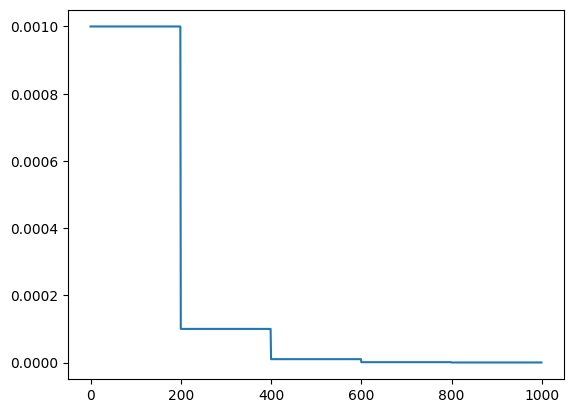

In [19]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

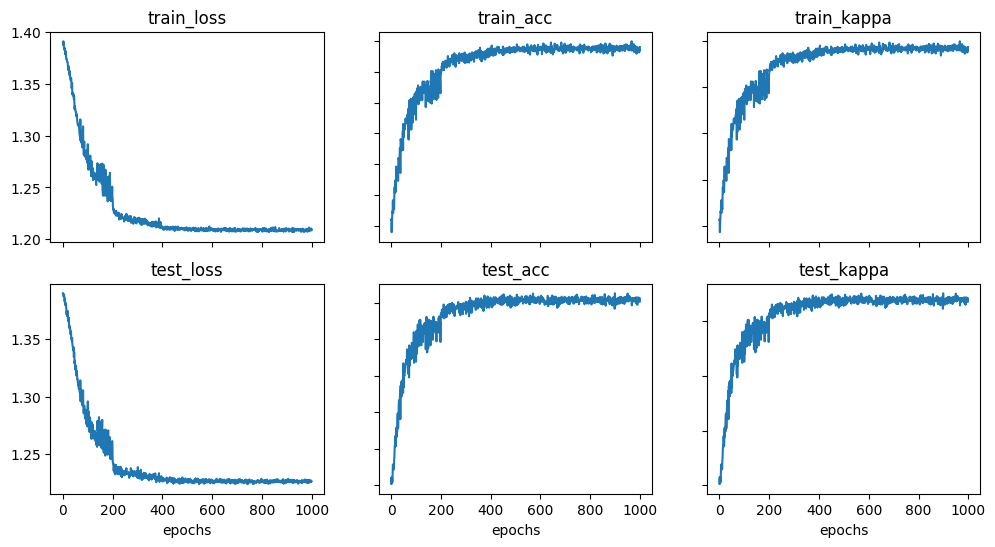

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [36]:
a = 0.3549382716049383
print(f"{a:.2}")

0.35
